# Prelims

In [2]:
print('kernel running')

kernel running


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

from classes import make_model, subsequent_mask, NoamOpt, LabelSmoothing, PositionalEncoding, run_epoch, Batch, \
    greedy_decode
from transformer_mini import data_gen_list, SimpleLossCompute

## Greedy Decoding block

In [6]:
# Train the simple copy task.
epochs = 15
V = 11  # input symbols are integers from 1 to 11 inclusive
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)  # model is EncoderDecoder object
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Generate random data
data_batches = data_gen_list(V, 30, 5)  # old call: data_gen(V, 30, 20) (makes generator instead of list)
print('data_batches properties')
print(type(data_batches), 'lengths', len(data_batches), type(data_batches[0]), '\n')

# Train the model
loss_curve = [0] * epochs
for epoch in range(epochs):  # def 10
    ## calls nn.Module.train() which sets mode to train
    model.train()
    epoch_loss = run_epoch(data_batches, model,
                           SimpleLossCompute(model.generator, criterion, model_opt))
    
    loss_curve[epoch] = epoch_loss
    print('Epoch %d loss:' % epoch, epoch_loss)
    ## sets mode to testing (i.e. train=False).
    ## Layers like dropout behave differently depending on if mode is train or testing.
    model.eval()

data_batches properties
<class 'list'> lengths 5 <class 'classes.Batch'> 



c:\users\matts\appdata\local\programs\python\python37\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch Step: 1 Loss: 3.267837 Tokens per Sec: 380.717430
Epoch loss: tensor(3.0926)
Epoch Step: 1 Loss: 2.793461 Tokens per Sec: 447.723012
Epoch loss: tensor(2.7064)
Epoch Step: 1 Loss: 2.341999 Tokens per Sec: 441.496648
Epoch loss: tensor(2.2314)
Epoch Step: 1 Loss: 2.111100 Tokens per Sec: 445.122369
Epoch loss: tensor(2.0417)
Epoch Step: 1 Loss: 1.918459 Tokens per Sec: 444.771241
Epoch loss: tensor(1.8712)
Epoch Step: 1 Loss: 1.786136 Tokens per Sec: 413.229132
Epoch loss: tensor(1.7837)
Epoch Step: 1 Loss: 1.775763 Tokens per Sec: 414.368202
Epoch loss: tensor(1.6844)
Epoch Step: 1 Loss: 1.644130 Tokens per Sec: 449.590246
Epoch loss: tensor(1.5887)
Epoch Step: 1 Loss: 1.500911 Tokens per Sec: 440.516283
Epoch loss: tensor(1.4818)
Epoch Step: 1 Loss: 1.483034 Tokens per Sec: 441.854775
Epoch loss: tensor(1.4087)
Epoch Step: 1 Loss: 1.288046 Tokens per Sec: 435.790710
Epoch loss: tensor(1.2567)
Epoch Step: 1 Loss: 1.243362 Tokens per Sec: 445.737058
Epoch loss: tensor(1.2924)
Epoc

Text(0, 0.5, 'Loss')

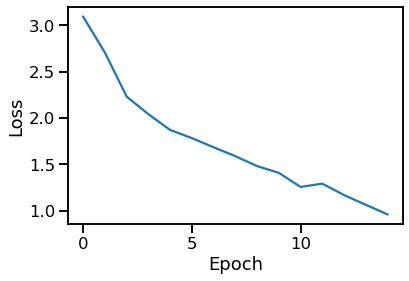

In [18]:
plt.plot(range(epochs), loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [19]:
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  3,  2,  4,  5,  6,  7, 10,  9,  8]])


In [20]:
src = Variable(torch.LongTensor([[1, 1, 3, 2, 9, 1, 7, 1, 9, 1]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 3, 3, 3, 2, 1, 9, 1, 9, 1]])


In [31]:
def greedy_decode_local(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    print('memory:', type(memory), memory.dim(), memory.shape)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    print(ys)
    print(type(ys), ys.dim(), ys.shape)
    
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        print(ys)
        print(type(ys), ys.dim(), ys.shape)
        
    return ys

In [32]:
src = Variable(torch.LongTensor([[1, 1, 3, 2, 9, 1, 7, 1, 9, 1]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode_local(model, src, src_mask, max_len=10, start_symbol=1))

memory: <class 'torch.Tensor'> 3 torch.Size([1, 10, 512])
tensor([[1]])
<class 'torch.Tensor'> 2 torch.Size([1, 1])
tensor([[1, 3]])
<class 'torch.Tensor'> 2 torch.Size([1, 2])
tensor([[1, 3, 3]])
<class 'torch.Tensor'> 2 torch.Size([1, 3])
tensor([[1, 3, 3, 3]])
<class 'torch.Tensor'> 2 torch.Size([1, 4])
tensor([[1, 3, 3, 3, 2]])
<class 'torch.Tensor'> 2 torch.Size([1, 5])
tensor([[1, 3, 3, 3, 2, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 6])
tensor([[1, 3, 3, 3, 2, 1, 9]])
<class 'torch.Tensor'> 2 torch.Size([1, 7])
tensor([[1, 3, 3, 3, 2, 1, 9, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 8])
tensor([[1, 3, 3, 3, 2, 1, 9, 1, 9]])
<class 'torch.Tensor'> 2 torch.Size([1, 9])
tensor([[1, 3, 3, 3, 2, 1, 9, 1, 9, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 10])
tensor([[1, 3, 3, 3, 2, 1, 9, 1, 9, 1]])
